In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
from os.path import join as jp
from functools import partial

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.cm as cm
import matplotlib.lines as mlines
from pylab import rc
from skimage.measure import label
import seaborn as sns

from dpipe.medim.metrics import fraction, dice_score
from dpipe.io import load_json, save_json, load_pred
from iw.metric import exp2prc_df, get_prc, get_size_df
from iw.utils import np_sigmoid, get_pred, get_iw_dir_name

In [27]:
met_path = jp(get_iw_dir_name(), '../froc_data/met/')
luna_path = jp(get_iw_dir_name(), '../froc_data/luna/')
lits_path = jp(get_iw_dir_name(), '../froc_data/lits/')


rc('axes', linewidth=2)


def f_luna(d):
    if d < 8:
        return 'small'
    else:
        return 'large'
    
    
def f_met(d):
    if d < 5:
        return 'small'
    else:
        return 'large'
    
    
def f_lits(d):
    if d < 12:
        return 'small'
    else:
        return 'large'
    
    
def path2title(exp_path):
    if 'luna' in exp_path:
        return 'LUNA16'
    elif 'met' in exp_path:
        return 'Metastases'
    elif 'lits' in exp_path:
        return 'LiTS'


def bootstrap_prc_df(df, n_ids, thresholds, with_logits=False, n_iter=10, sample_fraction=0.8, seed=42):
    ids = np.unique(df['id'])
    n_samples = int(len(ids) * sample_fraction)
    rs = np.random.RandomState(seed=seed)
    
    prcs = []
    for n in range(n_iter):
        rs.shuffle(ids)
        iter_ids = ids[:n_samples]
        iter_df = df[np.array([True if _id in iter_ids else False for _id in df['id']])]
        
        if with_logits:
            prc_iter = get_prc(iter_df, thresholds=thresholds, self_stat='self_logit', hit_stat='hit_logit')
        else:
            prc_iter = get_prc(iter_df, thresholds=thresholds)
            
        prc_iter['avgFP'] = np.array(prc_iter['totalFP']) / n_ids
        
        prcs.append(prc_iter)
        
    return prcs


def average_prcs(prcs, axis, max_fp=6):
    x_points = np.linspace(0, max_fp, max_fp*100+1)
    ys = []
    for prc in prcs:
        ys.append(np.interp(x_points, prc[axis[0]][::-1], prc[axis[1]][::-1]))
        
    ys = np.array(ys)
    mean_y = np.mean(ys, axis=0)
    std_y = np.std(ys, axis=0)
    
    return x_points, mean_y, std_y


# ================================================================================================================
    
    
def prc2luna_metric(prc, axis, max_fp):
    # luna metric
    assert axis[0] == 'avgFP' and axis[1] == 'recall'
    
    prc0, prc1 = list(prc[axis[0]]), list(prc[axis[1]])
    prc0.append(0)
    prc1.append(0)
    x_points = np.linspace(0, max_fp, max_fp*100+1)
    # x_points = [0.125, 0.25, 0.5, 1, 2, 4, 8]
    luna_metric = np.mean(np.interp(x_points, prc0[::-1], prc1[::-1]))
        
    return luna_metric
        
        
# ================================================================================================================


def plot_froc(ax, exp_path, with_metric=False, with_logits=True):
    # ### SETUP OF FROC ###
    is_luna = 'luna' in exp_path
    
    label = exp_path.split('/')[-1]
    if len(label) == 0:
        label = exp_path.split('/')[-2]
    
    axis=['avgFP', 'recall']
    label2label = {'bce': 'BCE', 'iwbce': 'BCE + iw',
                   'asl': 'ASL', 'iwasl': 'ASL + iw',
                   'fl': 'Focal Loss', 'iwfl': 'Focal Loss + iw',
                   'dl': 'Dice Loss', 'iwdl': 'Dice Loss + iw'}
    label2color = {'bce': '#2274A5', 'iwbce': '#2274A5',
                   'asl': '#E83F6F', 'iwasl': '#E83F6F',
                   'fl': '#32936F', 'iwfl': '#32936F',
                   'dl': '#FFBF00', 'iwdl': '#FFBF00'}
    linestyle = '-' if 'iw' in label else '--'

    thresholds = np_sigmoid(np.linspace(-0.1, 10, num=51))
        
    
    # ### load df ###
    n_val = len([exp_n for exp_n in os.listdir(exp_path) if 'experiment_' in exp_n])
    df = exp2prc_df(exp_path, n_val=n_val)
    
    if 'luna' in exp_path:
        f_dim = f_luna
    elif 'met' in exp_path:
        f_dim = f_met
    else:
        f_dim = f_lits
    df['size'] = df['diameter'].apply(f_dim)
    
    df.reset_index(inplace=True, drop=True)
    n_ids = len(np.unique(df.id))
    
    
    if with_logits:
        max_logit = np.max(df[(df['self_logit'] > -np.inf) & (df['self_logit'] < np.inf)]['self_logit'])
        thresholds = np.concatenate((np.linspace(-0.1, 10, num=101), np.linspace(10, max_logit+1, num=100)))
        prc = get_prc(df, thresholds=thresholds, hit_stat='hit_logit', self_stat='self_logit')
    else:
        thresholds = np_sigmoid(np.linspace(0, 10, num=51))
        prc = get_prc(df, thresholds=thresholds)
        
    prc['avgFP'] = np.array(prc['totalFP']) / n_ids
        
    prcs = bootstrap_prc_df(df, n_ids, thresholds, with_logits=with_logits)
    x, y, std_y = average_prcs(prcs, axis, max_fp=np.min([np.max(prc['avgFP']), 6]))
    
    # ### plot ###
    ax.plot(x, y, color=label2color[label], linestyle=linestyle, label=label2label[label], linewidth=3)
    ax.fill_between(x, y - std_y, y + std_y, color=label2color[label], alpha=0.2)

    # ### metrics calculation (only with total size (i == 1)) ###
    if with_metric and inst == 'total':
        # object-wise Dice Score
        avg_dice, std_dice = prc['avg_dice'][0], prc['std_dice'][0]
        print(path2title(exp_path), label, '(object Dice):', f'{avg_dice:.2f}', '+-', f'{std_dice:.2f}')

        # avg-std for luna metric:
        max_fp = 5
        luna_metrics = []
        for _prc in prcs:
            luna_metrics.append(prc2luna_metric(_prc, axis, max_fp))
        print(path2title(exp_path), label, 
              '(avg Recall):', f'{np.mean(luna_metrics):.2f}', '+-', f'{np.std(luna_metrics):.2f}')

        print(' ')


def experiments2plot(with_metric=False, with_logits=True):
    
    # TODO: it is a nice idea to replace `+` with `jp`
    met_paths1 = [met_path + 'iwdl', met_path + 'dl', met_path + 'iwbce', met_path + 'bce']
    met_paths2 = [met_path + 'iwasl', met_path + 'asl', met_path + 'iwfl', met_path + 'fl']
    luna_paths1 = [luna_path + 'iwdl', luna_path + 'dl', luna_path + 'iwbce', luna_path + 'bce']
    luna_paths2 = [luna_path + 'iwasl', luna_path + 'asl', luna_path + 'iwfl', luna_path + 'fl']
    lits_paths1 = [lits_path + 'iwdl', lits_path + 'dl', lits_path + 'iwbce', lits_path + 'bce']
    lits_paths2 = [lits_path + 'iwasl', lits_path + 'asl', lits_path + 'iwfl', lits_path + 'fl']
#     paths = [[luna_paths1, luna_paths1, luna_paths2, luna_paths2],
#              [met_paths1, met_paths1, met_paths2, met_paths2],
#              [lits_paths1, lits_paths1, lits_paths2, lits_paths2],]
    paths = [[luna_paths1, met_paths1, lits_paths1],
             [luna_paths2, met_paths2, lits_paths2],]
    
#     rows, cols, size = 3, 4, 6
    rows, cols, size = 2, 3, 6
    fig, axs = plt.subplots(rows, cols, figsize=(size * cols + 3, size * rows),
                            sharey=True, sharex=True, dpi=200)
    
    for i in tqdm_notebook(range(rows)):
        for j in range(cols):
            ax = axs[i, j]
            inst = 'total'
            dataset_name = path2title(paths[i][j][0])
            
            ax.set_xlim((0, 6.1))
            ax.set_ylim((0, 1.02))
            
            ax.xaxis.set_tick_params(labelsize=25, width=3, length=7)
            ax.yaxis.set_tick_params(labelsize=25, width=3, length=7)
            if i == 0:
                ax.set_title(dataset_name, fontsize=30)    
            
            if i == 1:
                ax.set_xlabel('Average FP', fontsize=30)
                ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
                ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5], minor=True)

            if j == 0:
                ax.set_ylabel('Recall', fontsize=30)
                ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
                ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9], minor=True)
                
#             if j == 3:
#                 ax.set_ylabel(dataset_name, fontsize=30, fontweight='bold')
#                 ax.yaxis.set_label_position("right")

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            
            for path in paths[i][j]:
                plot_froc(ax, path, with_metric=with_metric, with_logits=with_logits)
                
            if j == 2:
                ax.legend(fontsize=28, loc='lower right')
    
    plt.tight_layout()
    plt.savefig(jp(get_iw_dir_name(), '../plots/froc_camera_ready.pdf'), dpi=150, bbox_inches='tight')
    plt.show()

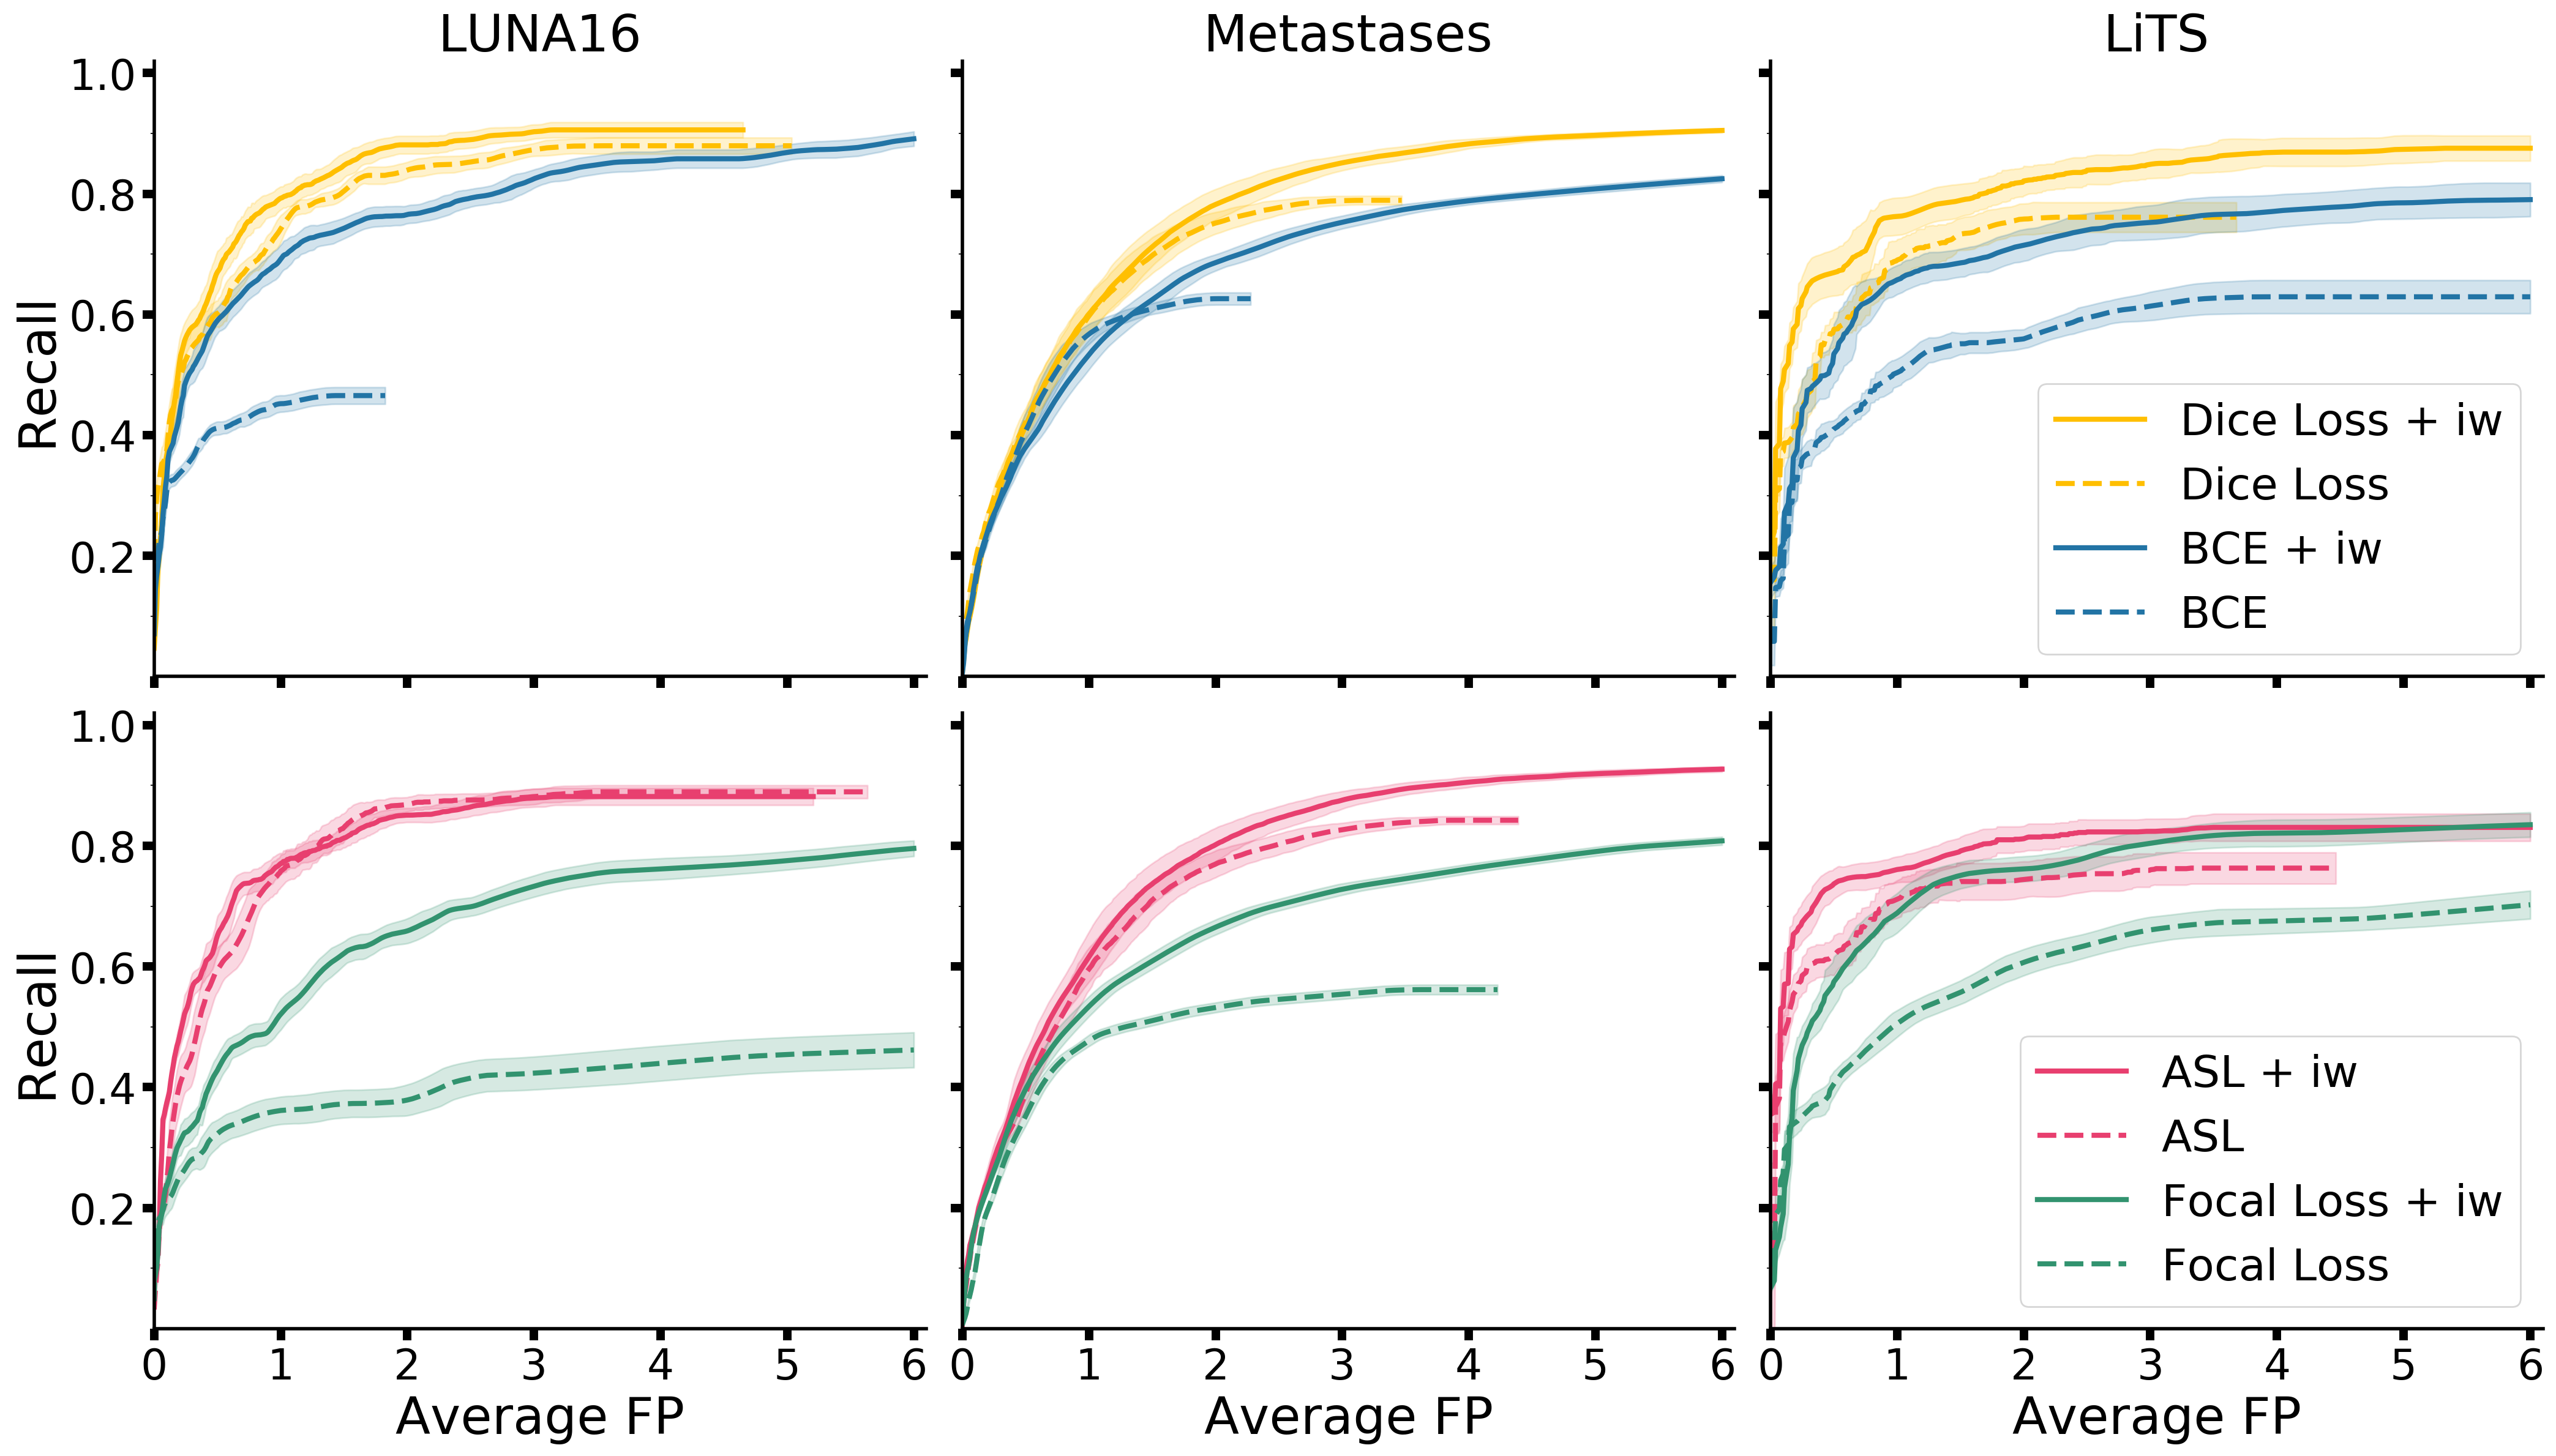

In [10]:
experiments2plot()

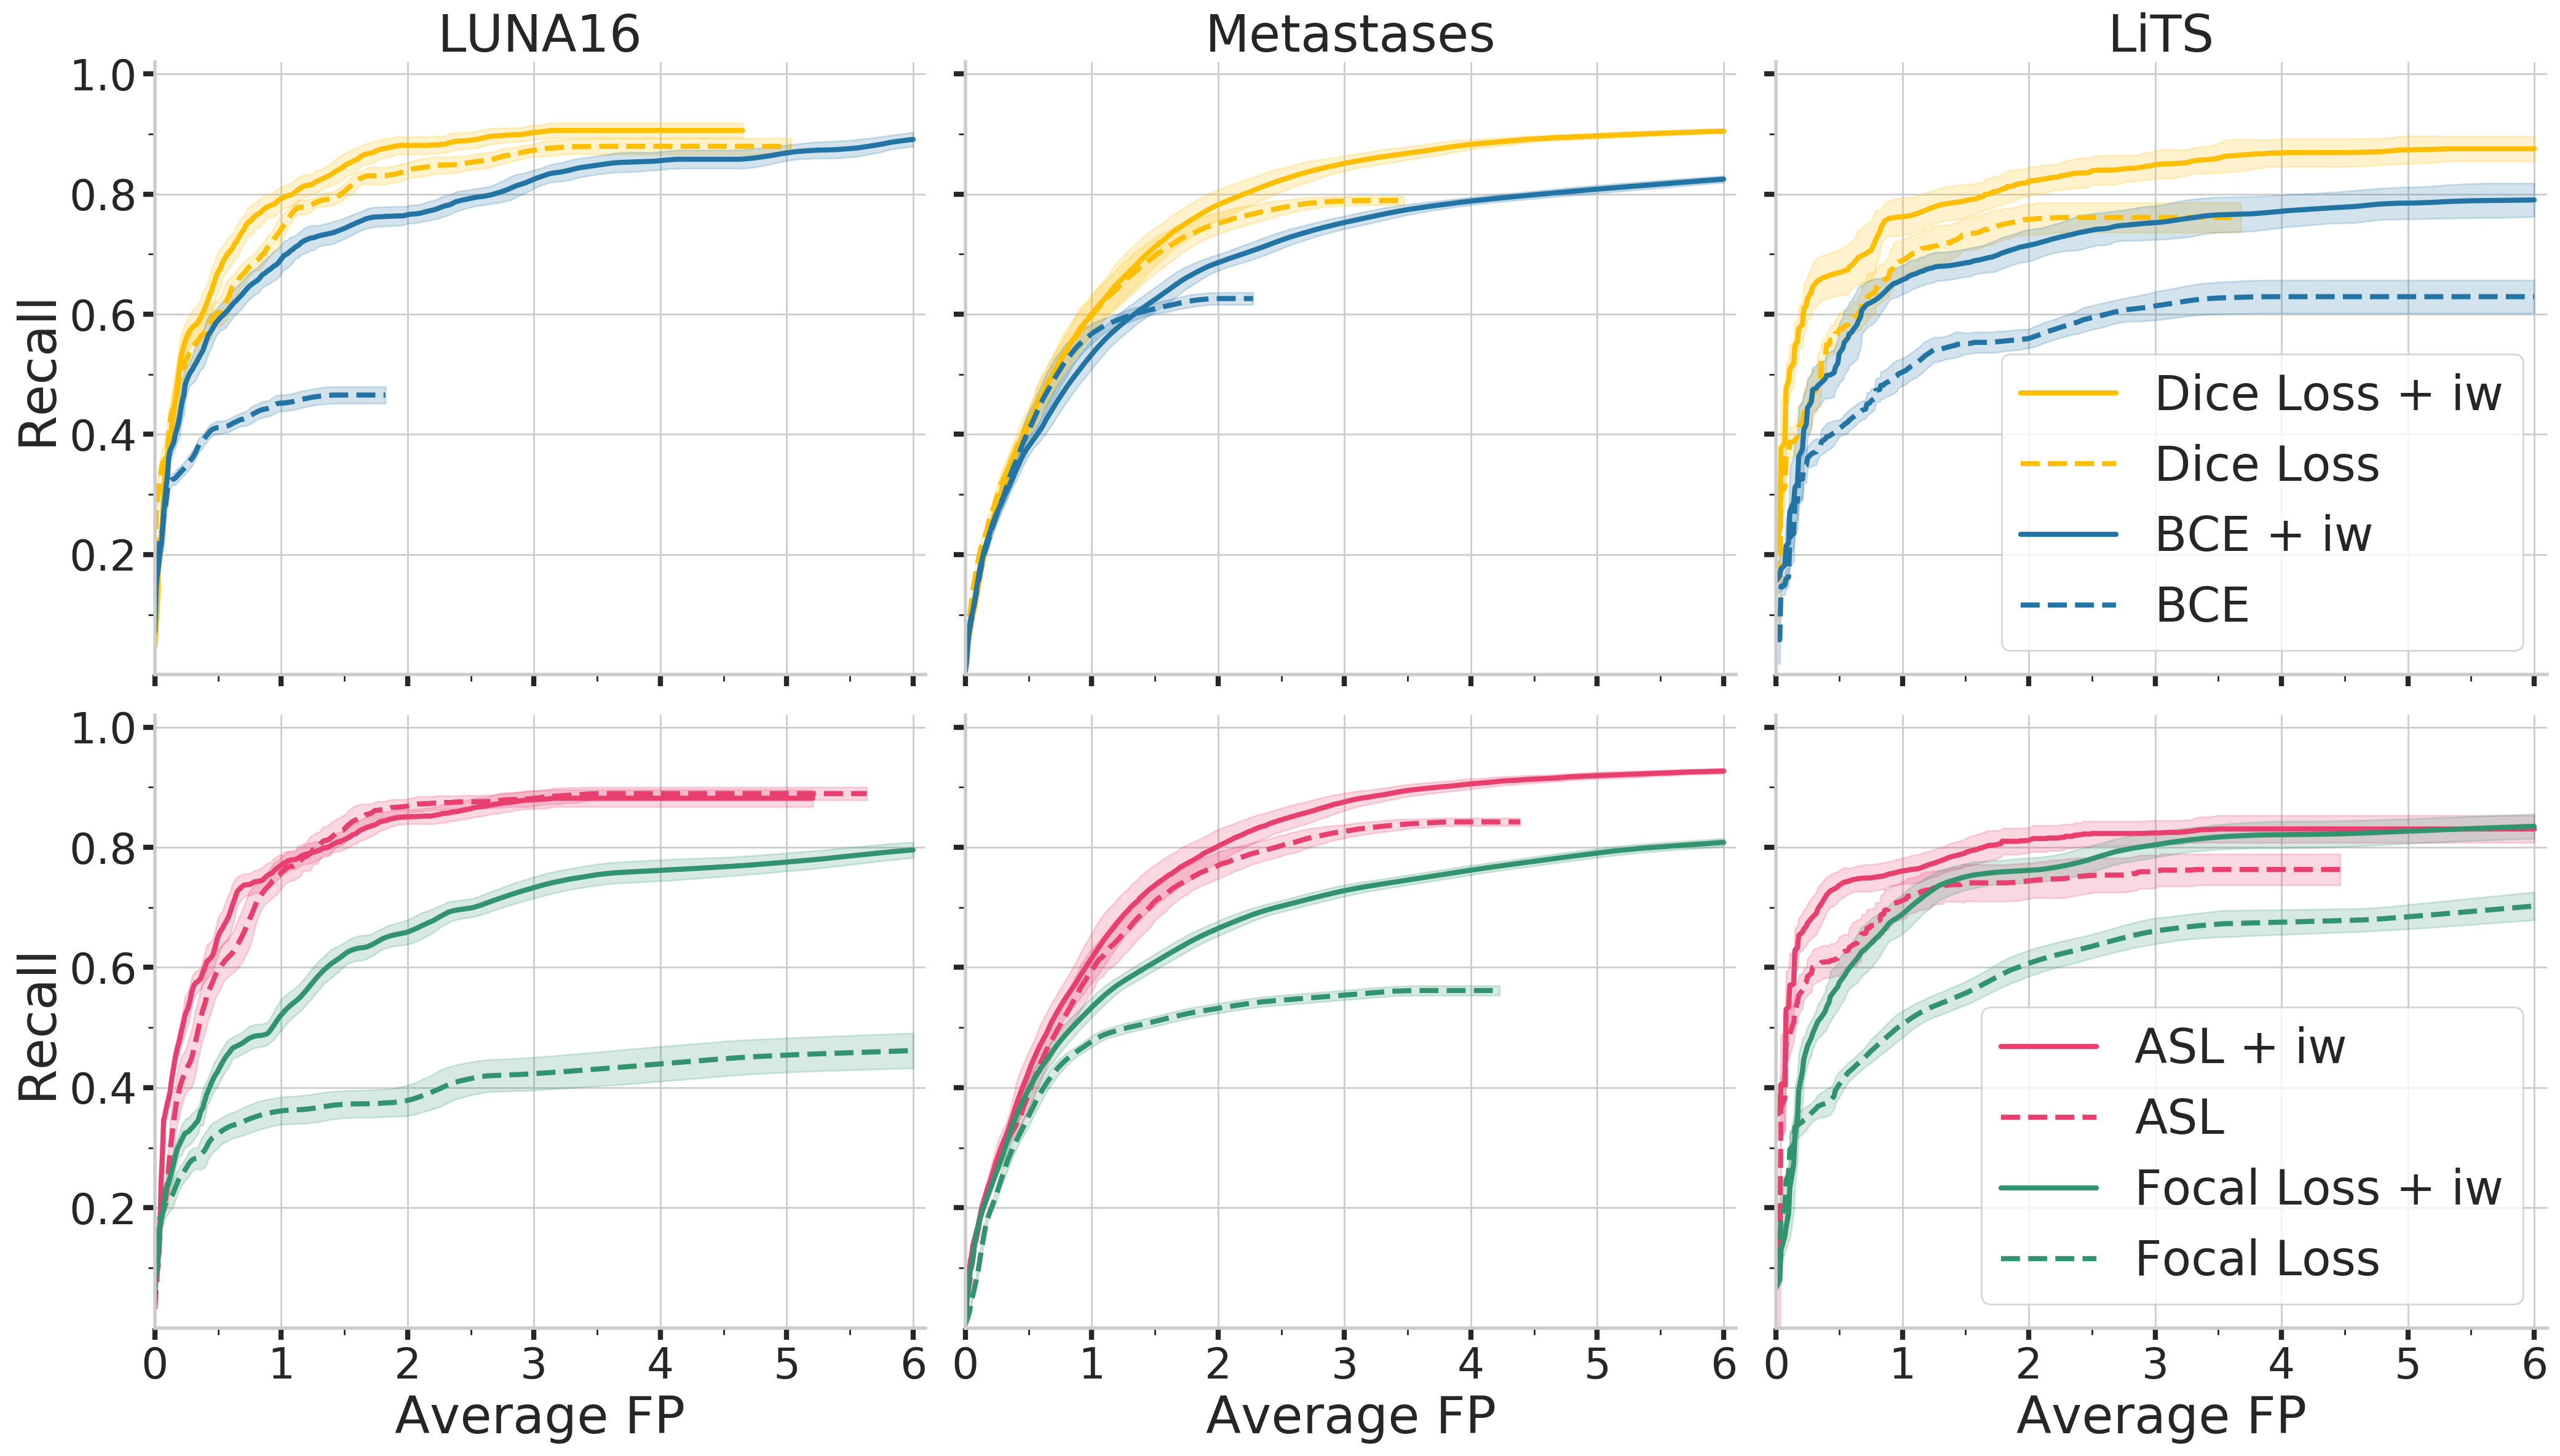

In [28]:
import seaborn as sns
sns.set_style('whitegrid', {'xtick.bottom': True, 'ytick.left': True});

experiments2plot()

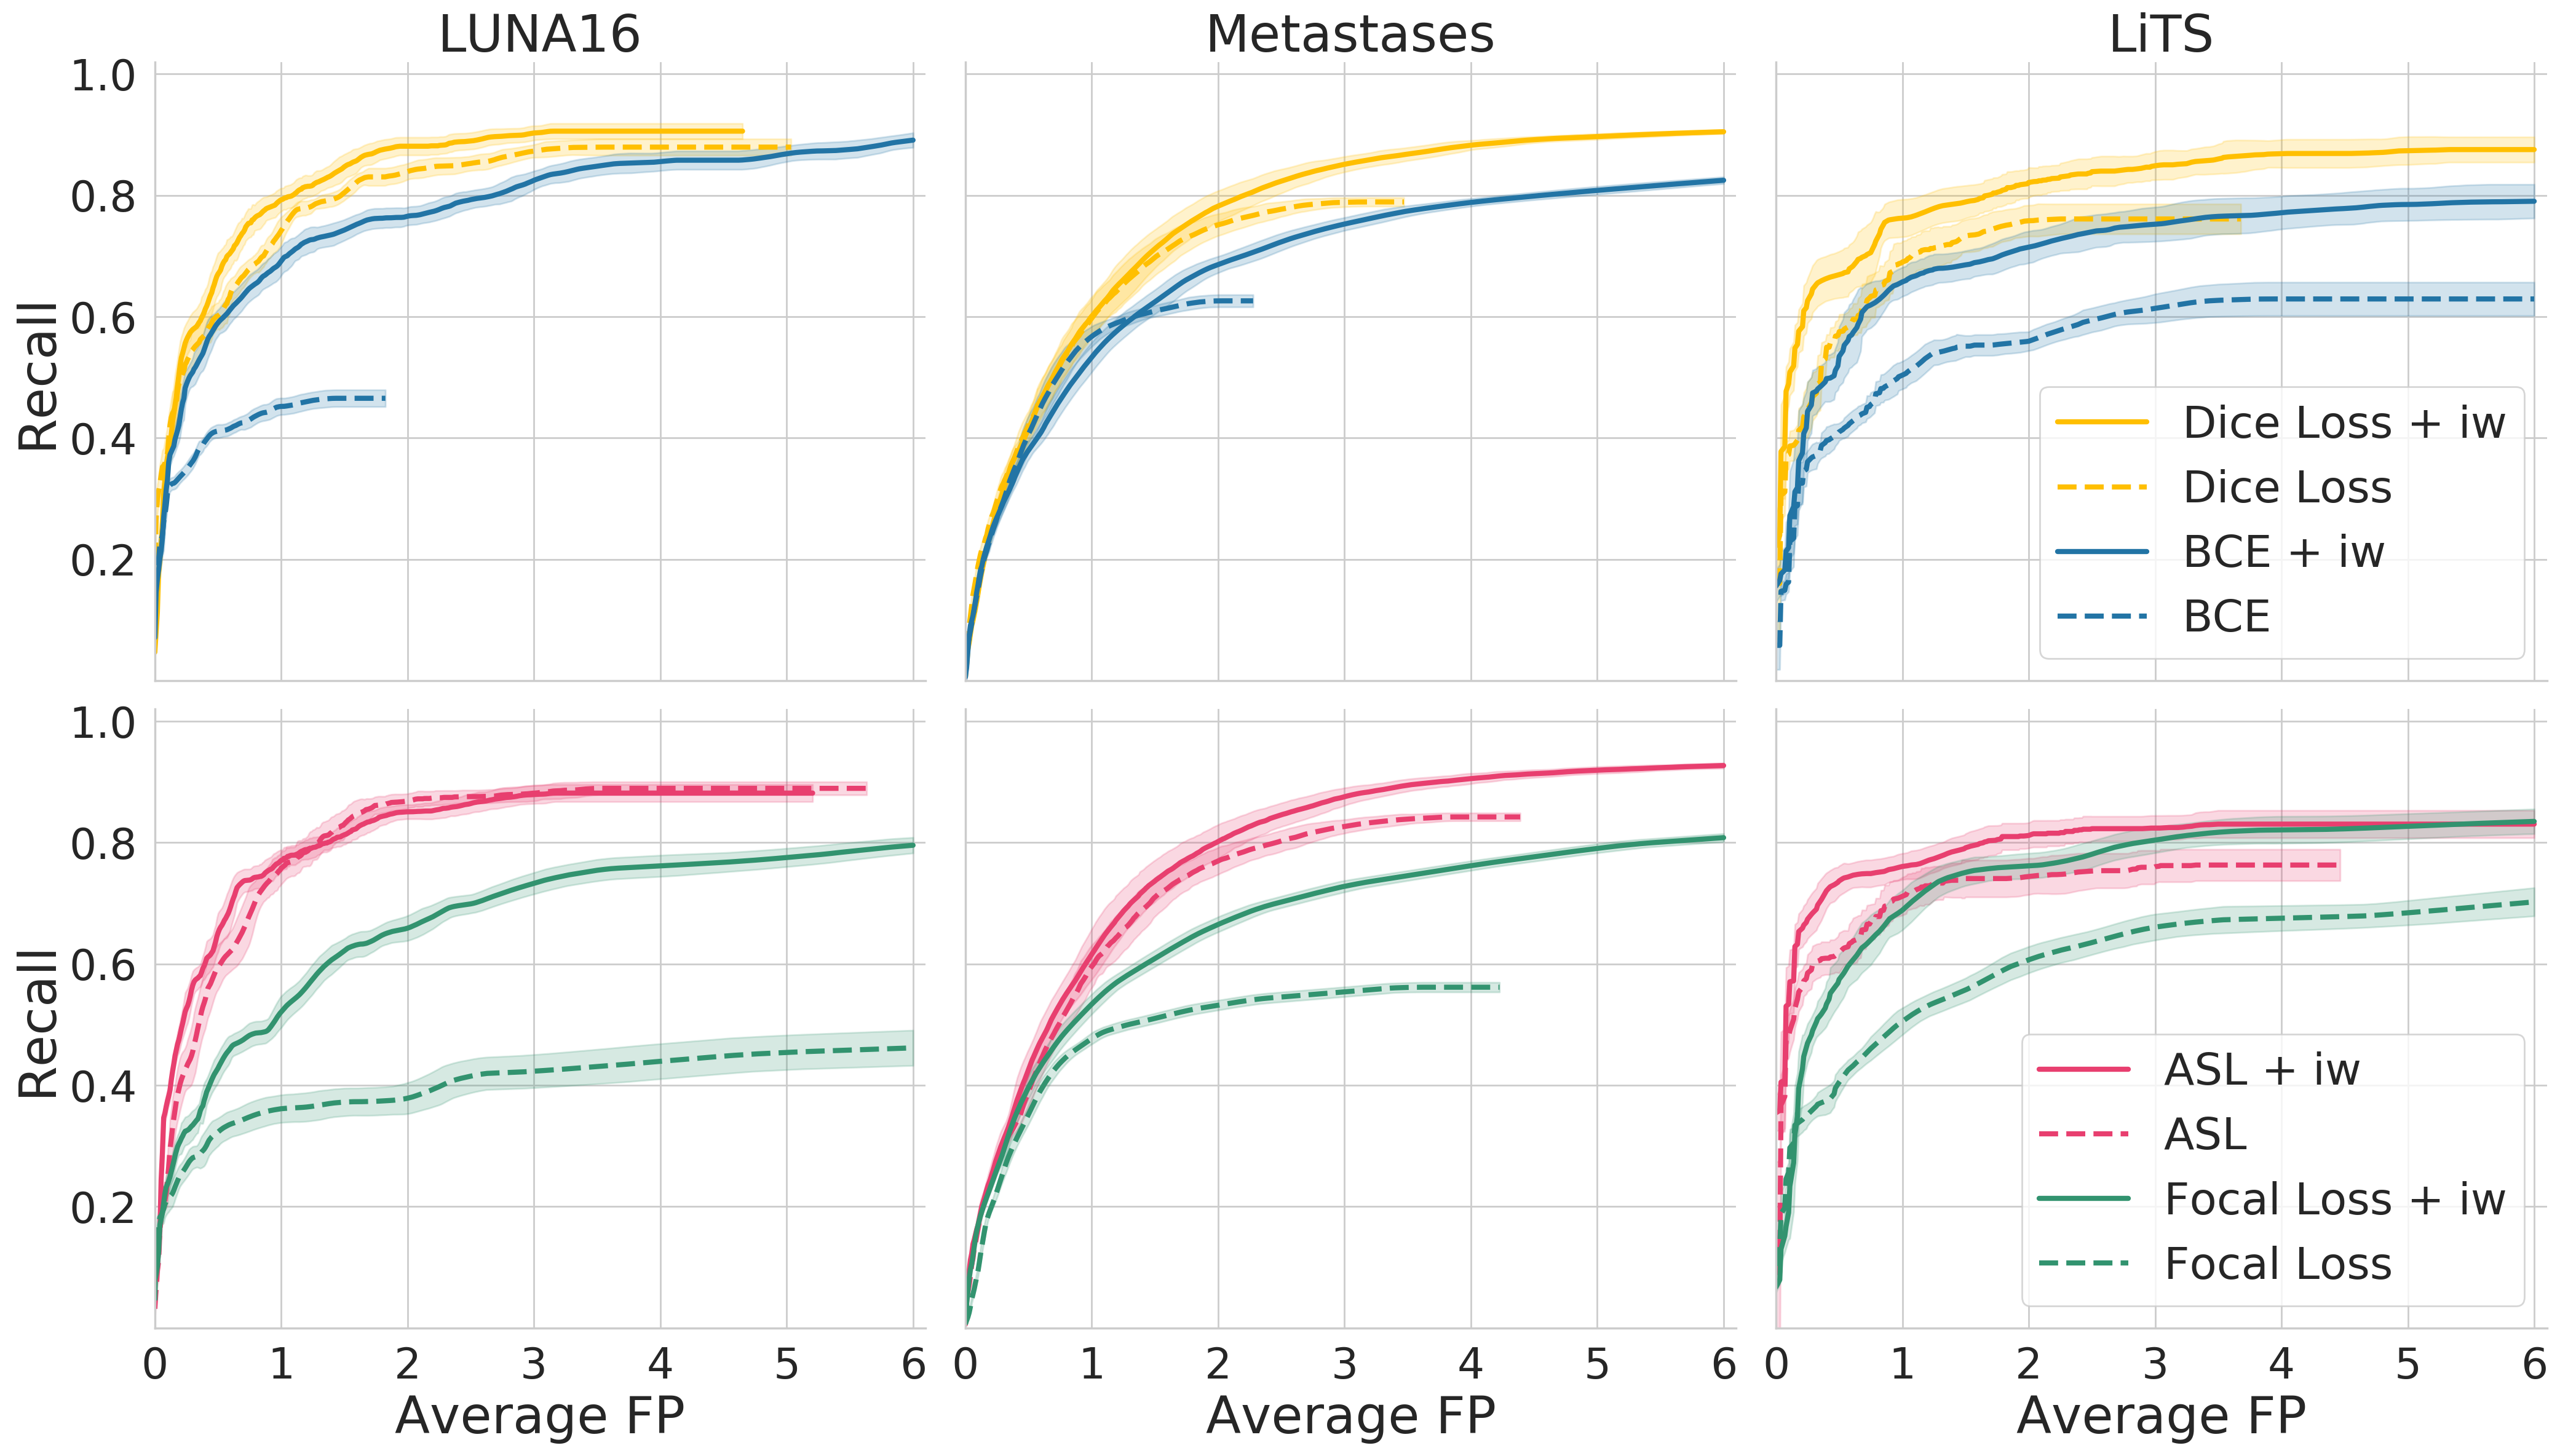

In [17]:
import seaborn as sns
sns.set(style='whitegrid');

experiments2plot()